In [1]:
import sys
sys.path.append('/Users/ik/Desktop/zepeto')
from a_python.rigging_class.rig_hier_maya_torch import *
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle as pkl
import scipy
import torch
import math
import time
import pytorch3d
from a_python.utils.rot import _rot_base
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    OpenGLOrthographicCameras,
    FoVPerspectiveCameras, 
    PointLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader
)
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer.mesh.rasterize_meshes import rasterize_meshes_python

from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer.blending import sigmoid_alpha_blend, _sigmoid_alpha



# Functions

## utils

In [2]:
def _rot_base(axis, angle):
    zero = torch.zeros_like(angle)
    one = torch.ones_like(angle)
    if axis == 'x':
        return torch.stack(
            [
                torch.stack([one, zero, zero]),
                torch.stack([zero, torch.cos(angle), -torch.sin(angle)]),
                torch.stack([zero, torch.sin(angle), torch.cos(angle)])
            ]
        )

    if axis == 'y':
        return torch.stack(
            [
                torch.stack([torch.cos(angle), zero, torch.sin(angle)]),
                torch.stack([zero, one, zero]),
                torch.stack([-torch.sin(angle), zero, torch.cos(angle)])
            ]
        )

    if axis == 'z':
        return torch.stack(
            [
                torch.stack([torch.cos(angle), -torch.sin(angle), zero]),
                torch.stack([torch.sin(angle), torch.cos(angle), zero]),
                torch.stack([zero, zero, one]),
            ]
        )

def visualize_vertices_torch(_vertices_opt, body_init, __color=np.array([0.5,0.3,1]), _chosen_idx=None):
    _list_joint = []
    pcd = o3d.geometry.PointCloud()
    _vertices_draw = np.asarray(copy.deepcopy(_vertices_opt.detach()))

    pcd.points = o3d.utility.Vector3dVector(_vertices_draw)
    _color = np.ones([9067,3])*__color
    
    if _chosen_idx is not None:
        _color[_chosen_idx,:] = np.array([1, 0, 0])
    pcd.colors = o3d.utility.Vector3dVector(_color)
    
    _list_joint.append(pcd)
    body_init.draw_joint(_list_joint)
    o3d.visualization.draw_geometries(_list_joint)


## upperbody

In [3]:
def img_upperbody_maya_joints(keypts):
    '''maya관절 길이비율대로 상체 조인트 추가 : chest upper, chest, spine'''
    img_hip = (keypts[9,:2] + keypts[12,:2])/2
    img_neck = (keypts[2,:2] + keypts[5,:2])/2
    img_spine = (img_neck - img_hip) * len_joint_upper[-1] + img_hip
    img_chest = (img_neck - img_hip) * (len_joint_upper[-1] + len_joint_upper[-2]) + img_hip
    img_chsetupper = (img_neck - img_hip) * (len_joint_upper[-1] + len_joint_upper[-2] + len_joint_upper[-3])  + img_hip
    return img_hip, img_neck, img_spine, img_chest, img_chsetupper

def fitting_based_on_upperbody_joints(body, img_spine, img_hip, img_neck, _vertices):
    '''img_upperbody_maya_joints 함수 결과 사용해서 메쉬 스케일링으로 상체 조인트위치 맞춤'''
    # hip to spine 거리
    _len_spine_maya = np.linalg.norm(body.head - body.childs[0].head) 
    _len_spine_img = np.linalg.norm(img_spine - img_hip)

    # 상체 조인트 맞춤
    _spine_trans = -(_len_spine_maya - _len_spine_img) * \
        ((-body.head + body.childs[0].head) / np.linalg.norm(body.head - body.childs[0].head))
    body.childs[0].trans_head(_spine_trans, _vertices)
    _scale_spine_hier = (np.linalg.norm(img_hip - img_neck) * len_joint_upper[-1]) / \
        (np.linalg.norm(body.childs[0].head - body.childs[0].childs[0].head))
    body.childs[0].scale_iso_hier(_scale_spine_hier, _vertices)
    
# TODO : 이거 말고 그냥 FK로 빨리 푸는걸로 바꾸기
# def upperbody_rigging_for_joint_matching(body,_vertices, opt_upper_scale, opt_upper_rot):
#     '''상체+팔 joint_matching용 rigging'''
#     # TODO rotation이랑 scale이랑 상대 스케일 노말라이즈 하기
#     body_init = copy.deepcopy(body)
#     _vertices_opt = copy.deepcopy(_vertices)

#     # spine
#     body_init.childs[0].scale_iso_hier(opt_upper_scale[0], _vertices_opt)
#     body_init.childs[0].rot(_rot_base('z', opt_upper_rot[0]), _vertices_opt, inplace=False)
#     # chestupper
#     body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', opt_upper_rot[1]), _vertices_opt, inplace=False)
#     # shoulder
#     body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
#     body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(opt_upper_scale[1], _vertices_opt)

#     # upperarm
#     ## left
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].scale_iso_hier(opt_upper_scale[2], _vertices_opt)
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].rot(_rot_base('x', -torch.abs(opt_upper_rot[2])), _vertices_opt, inplace=False)
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].rot(_rot_base('y', -torch.abs(opt_upper_rot[3])), _vertices_opt, inplace=False)
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].rot(_rot_base('z', -torch.abs(opt_upper_rot[4])), _vertices_opt, inplace=False)
#     ## right
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].scale_iso_hier(opt_upper_scale[2], _vertices_opt)
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].rot(_rot_base('x', torch.abs(opt_upper_rot[5])), _vertices_opt, inplace=False)
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].rot(_rot_base('y', torch.abs(opt_upper_rot[6])), _vertices_opt, inplace=False)
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].rot(_rot_base('z', torch.abs(opt_upper_rot[7])), _vertices_opt, inplace=False)

#     # lowerarm
#     ## left
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].childs[0].childs[0].scale_iso_hier(opt_upper_scale[3], _vertices_opt)
#     body_init.childs[0].childs[0].childs[0].childs[1].childs[0].childs[0].childs[0].rot(_rot_base('y', -torch.abs(opt_upper_rot[8])), _vertices_opt, inplace=False)
#     ## right
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].childs[0].childs[0].scale_iso_hier(opt_upper_scale[3], _vertices_opt)
#     body_init.childs[0].childs[0].childs[0].childs[2].childs[0].childs[0].childs[0].rot(_rot_base('y', torch.abs(opt_upper_rot[9])), _vertices_opt, inplace=False)
    
#     # joint
#     joint = []
#     # neck
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[0].T_mat[:3,3][None,:])
#     # Left
#     ## upperarm
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[1].childs[0].T_mat[:3,3][None,:])
#     ## lowerarm
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[1].childs[0].childs[0].childs[0].T_mat[:3,3][None,:])
#     ## hand
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[1].childs[0].childs[0].childs[0].childs[0].childs[0].T_mat[:3,3][None,:])
#     # Right
#     ## upperarm
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[2].childs[0].T_mat[:3,3][None,:])
#     ## lowerarm
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[2].childs[0].childs[0].childs[0].T_mat[:3,3][None,:])
#     ## hand
#     joint.append(body_init.childs[0].childs[0].childs[0].childs[2].childs[0].childs[0].childs[0].childs[0].childs[0].T_mat[:3,3][None,:])
#     joint = torch.cat(joint, dim=0)
    
#     joint_aligned = joint * torch.tensor([1,-1,1]) - _vertices_opt[3106,:]* torch.tensor([1,-1,1]) + torch.tensor([crotch[0], crotch[1], 0])

#     return body_init, _vertices_opt, joint_aligned

def upperbody_rigging_for_joint_matching_only_body(body,_vertices, opt_upper_scale, opt_upper_rot):
    '''상체 joint_matching용 rigging'''
    body_init = copy.deepcopy(body)
    _vertices_opt = copy.deepcopy(_vertices)

    # spine
    body_init.childs[0].scale_iso_hier(opt_upper_scale[0], _vertices_opt)
    body_init.childs[0].rot(_rot_base('z', opt_upper_rot[0]), _vertices_opt, inplace=False)
    # chestupper
    body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', opt_upper_rot[1]), _vertices_opt, inplace=False)
    # shoulder
    body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(opt_upper_scale[1], _vertices_opt)

    # joint
    joint = []
    # Left
    ## upperarm
    joint.append(body_init.childs[0].childs[0].childs[0].childs[1].childs[0].T_mat[:3,3][None,:])
    # Right
    ## upperarm
    joint.append(body_init.childs[0].childs[0].childs[0].childs[2].childs[0].T_mat[:3,3][None,:])
    
    joint = torch.cat(joint, dim=0)
    joint_aligned = joint * torch.tensor([1,-1,1]) - _vertices_opt[3106,:]* torch.tensor([1,-1,1]) + torch.tensor([crotch[0], crotch[1], 0])
    
    return body_init, _vertices_opt, joint_aligned

# def loss_dr_upper(body, _vertices, opt_upper_scale, opt_upper_rot, gt_joint):
#     '''상체 전체 맞추기(몸통 + 팔)'''
#     body_init, _vertices_opt, joint = upperbody_rigging_for_joint_matching(body, _vertices, opt_upper_scale, opt_upper_rot)
#     loss = torch.abs(gt_joint[:,:2] - joint[:,:2]).sum()
#     return loss

def loss_dr_upper_only_body(body, _vertices, opt_upper_scale, opt_upper_rot, gt_joint):
    '''상체 몸통만 DR로 맞추기'''
    body_init, _vertices_opt, joint = upperbody_rigging_for_joint_matching_only_body(body, _vertices, opt_upper_scale, opt_upper_rot)
    loss = torch.abs(gt_joint[:,:2] - joint[:,:2]).sum()
    return loss, joint



### upperbody optimize

In [4]:
def DR_rig_upper_body_only(body, _vertices, opt_upper_scale, opt_upper_rot, opt_x, crotch_subimg, h_sub, w_sub, mesh, img_weight, img_target):
    body_init = copy.deepcopy(body)
    _vertices_opt = copy.deepcopy(_vertices)

    # optimize paramters
    body_init.childs[0].scale_y(opt_x[0], _vertices_opt)
    body_init.childs[0].childs[0].scale_y(opt_x[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].scale_y(opt_x[2], _vertices_opt)

    # Prior result
    ## spine
    body_init.childs[0].scale_iso_hier(opt_upper_scale[0], _vertices_opt)
    body_init.childs[0].rot(_rot_base('z', opt_upper_rot[0]), _vertices_opt, inplace=False)
    ## chestupper
    body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', opt_upper_rot[1]), _vertices_opt, inplace=False)
    ## shoulder
    body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(opt_upper_scale[1], _vertices_opt)

def DR_upper_body_only(body, _vertices, opt_upper_scale, opt_upper_rot, opt_x, crotch_subimg, h_sub, w_sub, mesh, img_weight, img_target):
    fs_p_pix = 2 #8

    body_init = copy.deepcopy(body)
    _vertices_opt = copy.deepcopy(_vertices)

    # optimize paramters
    body_init.childs[0].scale_y(opt_x[0], _vertices_opt)
    body_init.childs[0].childs[0].scale_y(opt_x[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].scale_y(opt_x[2], _vertices_opt)

    # Prior result
    ## spine
    body_init.childs[0].scale_iso_hier(opt_upper_scale[0], _vertices_opt)
    body_init.childs[0].rot(_rot_base('z', opt_upper_rot[0]), _vertices_opt, inplace=False)
    ## chestupper
    body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', opt_upper_rot[1]), _vertices_opt, inplace=False)
    ## shoulder
    body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
    
    img_size = min(h_sub, w_sub)
    mesh._verts_packed = (
            _vertices_opt - _vertices_opt[3106,:]
            - torch.tensor([0, 0, -img_size/2])
            - torch.tensor([crotch_subimg[0], crotch_subimg[1], 0]) \
            + torch.tensor([w_sub/2, h_sub/2, 0])
            )/img_size * 2
    fragments = rasterize_meshes(mesh, image_size = (h_sub, w_sub), blur_radius=0, faces_per_pixel=fs_p_pix, perspective_correct= False, )
    blend_params = BlendParams()
    res = _sigmoid_alpha(fragments[3], fragments[0], blend_params.sigma)
    
    if img_weight is None:
        loss = (torch.abs(img_target - res)).sum()
    else:
        loss = (img_weight * torch.abs(img_target - res)).sum()

    return loss

def DR_upper_body_only_without_joint_change(body, _vertices, res_upper_scale, res_upper_rot, opt_x, crotch_subimg, h_sub, w_sub, mesh, img_weight, img_target):
    '''어깨 관절 정보는 변함없이 가기'''
    fs_p_pix = 2 #8

    body_init = copy.deepcopy(body)
    _vertices_opt = copy.deepcopy(_vertices)

    # optimize paramters
    body_init.childs[0].scale_y(opt_x[0], _vertices_opt)
    body_init.childs[0].childs[0].scale_y(opt_x[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].scale_y(opt_x[2], _vertices_opt)

    # Prior result
    ## spine
    body_init.childs[0].scale_iso_hier(res_upper_scale[0], _vertices_opt)
    body_init.childs[0].rot(_rot_base('z', res_upper_rot[0]), _vertices_opt, inplace=False)
    ## chestupper
    body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', res_upper_rot[1]), _vertices_opt, inplace=False)
    ## shoulder
    body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(res_upper_scale[1], _vertices_opt)
    body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(res_upper_scale[1], _vertices_opt)
    
    img_size = min(h_sub, w_sub)
    mesh._verts_packed = (
            _vertices_opt - _vertices_opt[3106,:]
            - torch.tensor([0, 0, -img_size/2])
            - torch.tensor([crotch_subimg[0], crotch_subimg[1], 0]) \
            + torch.tensor([w_sub/2, h_sub/2, 0])
            )/img_size * 2
    fragments = rasterize_meshes(mesh, image_size = (h_sub, w_sub), blur_radius=0, faces_per_pixel=fs_p_pix, perspective_correct= False, )
    blend_params = BlendParams()
    res = _sigmoid_alpha(fragments[3], fragments[0], blend_params.sigma)
    
    if img_weight is None:
        loss = (torch.abs(img_target - res)).sum()
    else:
        loss = (img_weight * torch.abs(img_target - res)).sum()

    return loss


# Code

## File info

In [17]:
# 사진 index
idx_img = 11
Draw = True

# optimize parameters
n_iter = 50
alpha_loss_excede_mask = 10          # 마스크 넘어가는거에 얼마나 가중치 줄건지

visualize_pcd = False

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


folder = idx_img
path_img = "/Users/ik/Downloads/test_set_new/{}/test_resized.png".format(folder)
path_json = "/Users/ik/Downloads/test_set_new/{}/test_resized_keypoints.json".format(folder)
path_dp = "/Users/ik/Downloads/test_set_new/{}/dp_dump.pkl".format(folder)

with open(path_json, 'r') as f:
    data = json.load(f)
with open(path_dp, 'rb') as f:
    [img_seg, img_v, img_u,_] = pkl.load(f)
h,w = img_seg.shape
keypts = torch.tensor(data['people'][0]['pose_keypoints_2d']).reshape([-1,3])

img = cv.imread(path_img)
x = np.linspace(0, w-1, w)
y = np.linspace(0, h-1, h)
xx, yy = np.meshgrid(x,y, indexing='xy')
img_size = h


# base mesh for face index
mesh = load_objs_as_meshes(['/Users/ik/Desktop/zepeto/blender/wip_find_weight.obj'], device)

# rigging class torch
body = rig_class(65)

idx_crotch = 3106


## 상체

### rasterize align

In [20]:
def verts_process_for_rasterize(verts, idx_interest, pos_interest_in_img, h_sub, w_sub):
    '''idx_interest를 subimg상에서 해당 위치로 align해서 rasterize 결과와 cropped img를 맞춤'''
    img_size = min(h_sub, w_sub)
    _verts_moved_for_rasterize_align_to_cropped = (
        verts - verts[idx_interest,:]
        - torch.tensor([0, 0, -img_size/2])
        - torch.tensor([pos_interest_in_img[0], pos_interest_in_img[1], 0]) \
        + torch.tensor([w_sub/2, h_sub/2, 0])
        )/img_size * 2    
    return _verts_moved_for_rasterize_align_to_cropped

scales: tensor(4.2325) , tensor(0.5332) , tensor(0.9561) , tensor(1.0943)


/opt/homebrew/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


0.4001181125640869


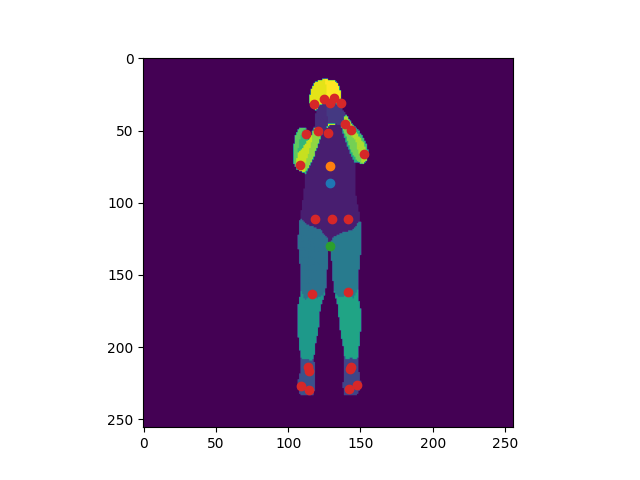

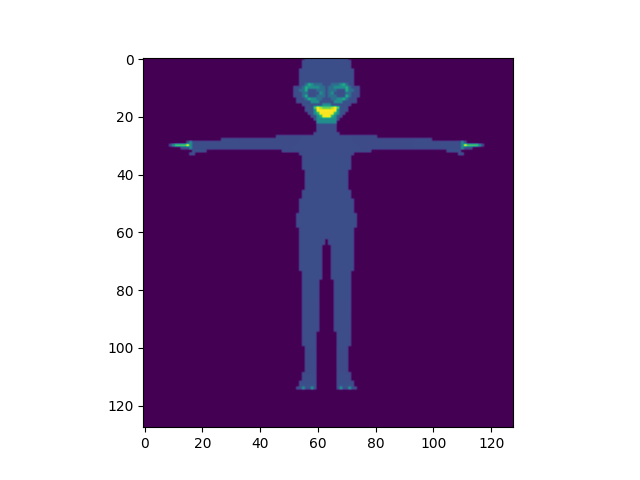

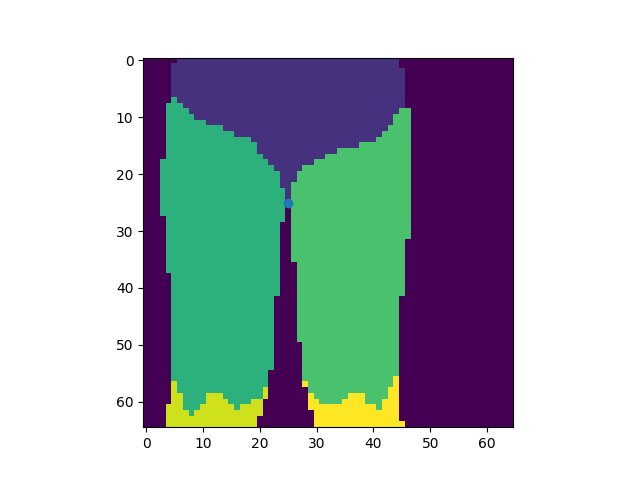

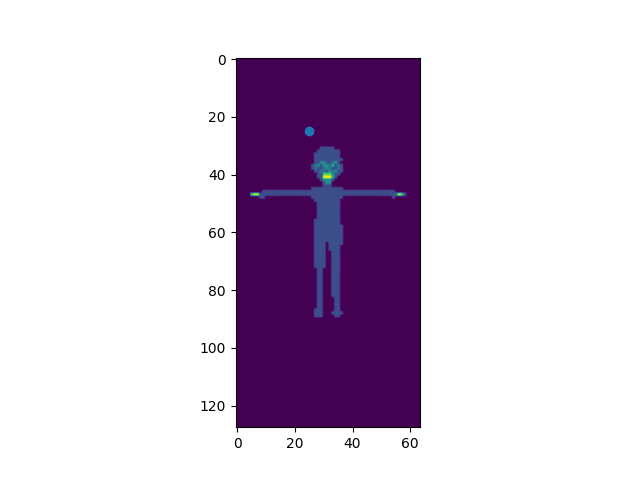

In [6]:
%matplotlib widget


_vertices = copy.deepcopy(vertices)
# 가랑이 찾고, 하체 다리길이 맞추기용 키포인트 길이 구하기 : 가랑이부분 허벅지 두께, 무릎, 발목 폭
# image랑 _vertices의 스케일이 같아짐 
crotch = body.scaling_joint_len(_vertices, keypts, img_seg)

# 길이비율로 상체 오픈포즈에 마야 조인트 추가, 메쉬 맞추기
img_hip, img_neck, img_spine, img_chest, img_chsetupper = img_upperbody_maya_joints(keypts)
fitting_based_on_upperbody_joints(body, img_spine, img_hip, img_neck, _vertices)


# 사이즈 잘 맞춰줬나 확인
if Draw:
    mesh._verts_list[0] = (
        _vertices - _vertices[3106,:] + torch.tensor([crotch[0], crotch[1], 0]) \
        - torch.tensor([img_size/2, img_size/2, -img_size/2])
        )/img_size * 2

    tmp_scale = torch.tensor([1.0])
    tmp_scale.requires_grad = True
    mesh._verts_list[0] *= tmp_scale
    
    pre =time.time()
    fragments = rasterize_meshes(mesh, image_size = int(img_size/2), blur_radius=0, faces_per_pixel=8,\
        perspective_correct= False, )
    print(time.time() - pre)
    
    plt.figure('check size aligning : img_seg')
    plt.imshow(img_seg)
    plt.scatter(img_chest[0], img_chest[1])
    plt.scatter(img_chsetupper[0], img_chsetupper[1])
    plt.scatter(crotch[0], crotch[1])
    plt.scatter(keypts[:,0], keypts[:,1])
    plt.figure('check size aligning : rasterize with only length matching')
    plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))




# body class 카피 - optimization에서 사용
body_init = copy.deepcopy(body)

img_mask = (img_seg!=0).astype(int)

# 허벅지 부분 이미지
thr_surplus = 3     # bouning box 여유분
mask_leg = (img_seg == 10) + (img_seg == 9)
bbox = np.array([[xx[mask_leg].min()-thr_surplus , yy[mask_leg].min()-thr_surplus],[xx[mask_leg].max()+thr_surplus , yy[mask_leg].max()+thr_surplus]]).astype(int)
_ul, _lr = torch.max(torch.abs(torch.from_numpy(bbox) - crotch), dim=1).values

rasterize_size = _ul+_lr

bbox = np.array([[crotch[0] - _ul, crotch[1] - _ul],[crotch[0] + _lr, crotch[1] + _lr]]).astype(int)
crotch_subimg = torch.tensor([_ul, _ul, 0])


# initial rasterization and subimage aligning
_vertices_opt = copy.deepcopy(_vertices)
## 허벅지 crop에 맞게 cropped rasterize
mesh_crotch = (
    _vertices_opt[3106,:] - _vertices_opt[3106,:] \
    - torch.tensor([crotch[0], crotch[1], 0]) \
    + torch.tensor([img_size/2, img_size/2, img_size/2])
    )/img_size * 2

mesh_crotch = mesh_crotch.detach()


move = torch.tensor([rasterize_size/2, rasterize_size/2, 0]) - crotch_subimg



# rasterization의 경우 normalize 해줘야함 [-1,1]
mesh._verts_list[0] = (
    _vertices - _vertices[3106,:] + torch.tensor([crotch[0], crotch[1], 0]) \
    - torch.tensor([img_size/2, img_size/2, -img_size/2])
    )/img_size * 2

tmp_scale = torch.tensor([1.0])
tmp_scale.requires_grad = True
mesh._verts_list[0] *= tmp_scale


fragments = rasterize_meshes(mesh, image_size = (128, 64), blur_radius=0, faces_per_pixel=8, perspective_correct= False, )

if True:
    plt.figure('subimg')
    plt.imshow(img_seg[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]])
    plt.scatter(crotch_subimg[0],crotch_subimg[1])

    plt.figure('rasterize_base')
    plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))
    plt.scatter(crotch_subimg[0],crotch_subimg[1])



### 몸통 컷

[    0     1     2 ... 17749 17750 17751]
13046
scales: tensor(4.2325) , tensor(0.5332) , tensor(0.9561) , tensor(1.0943)
torch.Size([1, 94, 50])


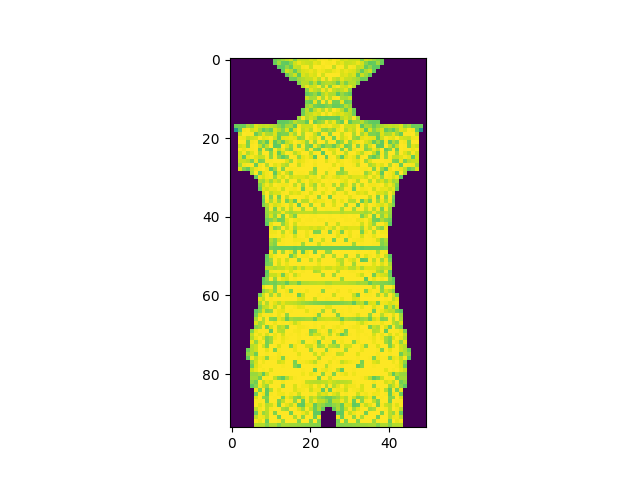

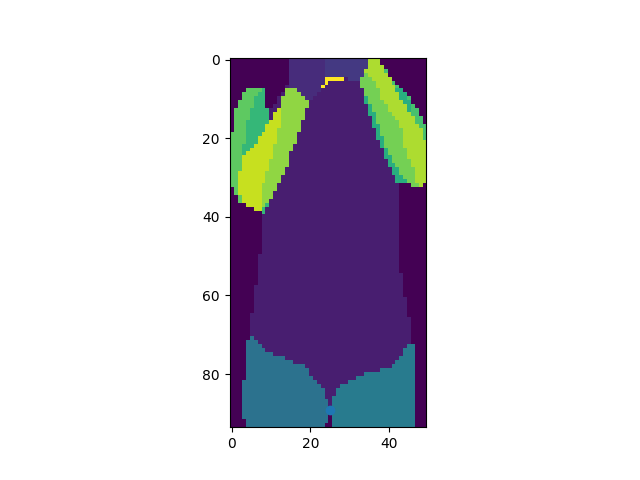

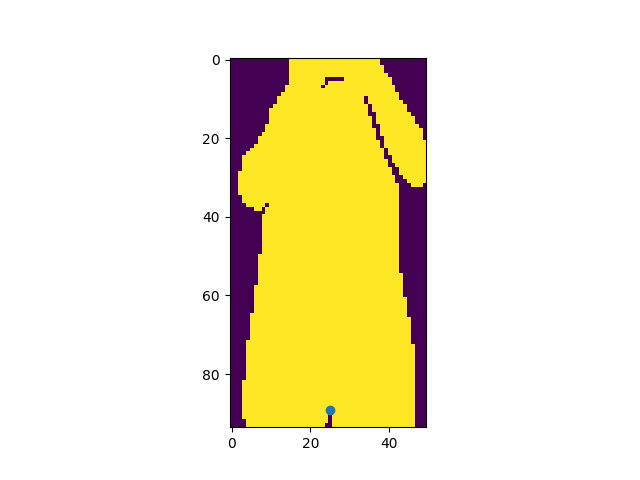

In [19]:
tmp_weight_R = torch.zeros(_vertices.shape[0])
body.childs[0].childs[0].childs[0].childs[2].childs[0].childs[0].concat_weights(tmp_weight_R)
tmp_weight_L = torch.zeros(_vertices.shape[0])
body.childs[0].childs[0].childs[0].childs[1].childs[0].childs[0].concat_weights(tmp_weight_L)

tmp_weight = tmp_weight_L + tmp_weight_R
idx_seg_hier = np.arange(_vertices.shape[0])[tmp_weight == 0]

if False:
    visualize_vertices_torch(_vertices, body, _chosen_idx=idx_seg_hier)

mesh = load_objs_as_meshes(['/Users/ik/Desktop/zepeto/blender/wip_find_weight.obj'], device)

idx_seg_hier = np.asarray(idx_seg_hier)
tmp_faces_list = np.asarray(mesh._faces_list[0])

corr_faces = np.isin(tmp_faces_list, idx_seg_hier).astype(int).sum(axis = 1) > 0
corr_faces = np.arange(corr_faces.shape[0])[corr_faces]
print(corr_faces)
print(corr_faces.shape[0])


_list = mesh._faces_list[0]
mesh._faces_list = [_list[corr_faces,:]]
mesh._num_faces_per_mesh[0] = corr_faces.shape[0]


mesh._verts_list[0] = (
    _vertices - _vertices[3106,:] + torch.tensor([crotch[0], crotch[1], 0]) \
    - torch.tensor([img_size/2, img_size/2, -img_size/2])
    )/img_size * 2

fragments = rasterize_meshes(mesh, image_size = int(img_size/2), blur_radius=0, faces_per_pixel=8, perspective_correct= False, )

%matplotlib widget
plt.figure('check body only mesh')
plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))
plt.figure('img_seg')
plt.imshow(img_seg)


thr_bbox = 5

h, w = img_seg.shape
x = np.linspace(0, w-1, w)
y = np.linspace(0, h-1, h)
xx, yy = np.meshgrid(x,y, indexing='xy')

mask_body = img_seg==2
bbox = np.array([
    [xx[mask_body].min()-thr_bbox , yy[mask_body].min()-thr_bbox],
    [xx[mask_body].max()+thr_bbox , yy[mask_body].max()+thr_bbox]
    ]).astype(int)

subimg = img_seg[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]]
h_sub, w_sub = subimg.shape
crotch_subimg = torch.tensor([int(crotch[0] - bbox[0,0]) , int(crotch[1] - bbox[0,1])])
mask_subimg1 = subimg < 23
mask_subimg2 = subimg == 0

mask_subimg3 = subimg == 15
mask_subimg4 = subimg == 16
mask_subimg5 = subimg == 17
mask_subimg6 = subimg == 18

mask_subimg = mask_subimg1.astype(int) - mask_subimg2.astype(int)- mask_subimg3.astype(int)- mask_subimg4.astype(int)- mask_subimg5.astype(int)- mask_subimg6.astype(int) 

#################### algin rasterization

_vertices = copy.deepcopy(vertices)
body = rig_class(65)
# 가랑이 찾고, 하체 다리길이 맞추기용 키포인트 길이 구하기 : 가랑이부분 허벅지 두께, 무릎, 발목 폭
# image랑 _vertices의 스케일이 같아짐 
crotch = body.scaling_joint_len(_vertices, keypts, img_seg)
# 길이비율로 상체 오픈포즈에 마야 조인트 추가, 메쉬 맞추기
img_hip, img_neck, img_spine, img_chest, img_chsetupper = img_upperbody_maya_joints(keypts)
fitting_based_on_upperbody_joints(body, img_spine, img_hip, img_neck, _vertices)


mesh._verts_packed = verts_process_for_rasterize(_vertices, idx_crotch, crotch_subimg, h_sub, w_sub)

fragments = rasterize_meshes(mesh, image_size = (h_sub, w_sub), blur_radius=0, faces_per_pixel=1, perspective_correct= False, )
# fragments = rasterize_meshes(mesh, image_size = 256, blur_radius=0, faces_per_pixel=8, perspective_correct= False, )
%matplotlib widget


if Draw:
    plt.figure('img_seg')
    plt.imshow(subimg)
    plt.scatter(crotch_subimg[0], crotch_subimg[1])
    plt.figure('img_mask')
    plt.imshow(mask_subimg)
    plt.scatter(crotch_subimg[0], crotch_subimg[1])
    plt.figure('img_rasterization align')
    plt.imshow(np.asarray(torch.sum(fragments[1][0], dim=2).detach()/8+1))

    fragments = rasterize_meshes(mesh, image_size = (h_sub, w_sub), blur_radius=0, faces_per_pixel=3, perspective_correct= False, )
    blend_params = BlendParams()
    res = _sigmoid_alpha(fragments[3], fragments[0], blend_params.sigma)
    print(res.shape)
    plt.imshow(np.asarray(res[0].detach()))
    plt.show()

In [8]:
# spine, shoulder
opt_upper_scale = torch.nn.Parameter(torch.tensor([1., 1.]))
# spine_z, chestuppper_z
opt_upper_rot = torch.nn.Parameter(torch.tensor([0., 0.])) 
# spine, chest, chestupper scale
opt_x = torch.nn.Parameter(torch.tensor([1., 1., 1.])) 
# optimizer = torch.optim.SGD([{'params' : opt_upper_scale}, {'params' : opt_upper_rot}], lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([{'params' : opt_upper_scale}, {'params' : opt_upper_rot}, {'params' : opt_x}], lr=0.01)
  

img_target = torch.from_numpy(mask_subimg)
img_weight = torch.from_numpy((mask_subimg - 1) * (-alpha_loss_excede_mask) + mask_subimg)

n_iter = 80
opt_list = []

for i in range(n_iter):
    optimizer.zero_grad()
    loss = DR_upper_body_only(body, _vertices, opt_upper_scale, opt_upper_rot, opt_x, crotch_subimg, h_sub, w_sub, mesh, img_weight, img_target)
    print('loss:', loss)
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        opt_list.append([opt_upper_scale, opt_upper_rot, opt_x])

loss: tensor(1530.1168, grad_fn=<SumBackward0>)
loss: tensor(1569.3521, grad_fn=<SumBackward0>)
loss: tensor(1499.2935, grad_fn=<SumBackward0>)
loss: tensor(1453.6304, grad_fn=<SumBackward0>)
loss: tensor(1442.9806, grad_fn=<SumBackward0>)
loss: tensor(1389.8594, grad_fn=<SumBackward0>)
loss: tensor(1373.6487, grad_fn=<SumBackward0>)
loss: tensor(1359.7954, grad_fn=<SumBackward0>)
loss: tensor(1352.2700, grad_fn=<SumBackward0>)
loss: tensor(1350.3281, grad_fn=<SumBackward0>)
loss: tensor(1353.6509, grad_fn=<SumBackward0>)
loss: tensor(1338.8265, grad_fn=<SumBackward0>)
loss: tensor(1349.6315, grad_fn=<SumBackward0>)
loss: tensor(1314.5391, grad_fn=<SumBackward0>)
loss: tensor(1275.5417, grad_fn=<SumBackward0>)
loss: tensor(1267.1350, grad_fn=<SumBackward0>)
loss: tensor(1227.5015, grad_fn=<SumBackward0>)
loss: tensor(1217.6173, grad_fn=<SumBackward0>)
loss: tensor(1273.0249, grad_fn=<SumBackward0>)
loss: tensor(1252.4021, grad_fn=<SumBackward0>)
loss: tensor(1257.2196, grad_fn=<SumBack

/opt/homebrew/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


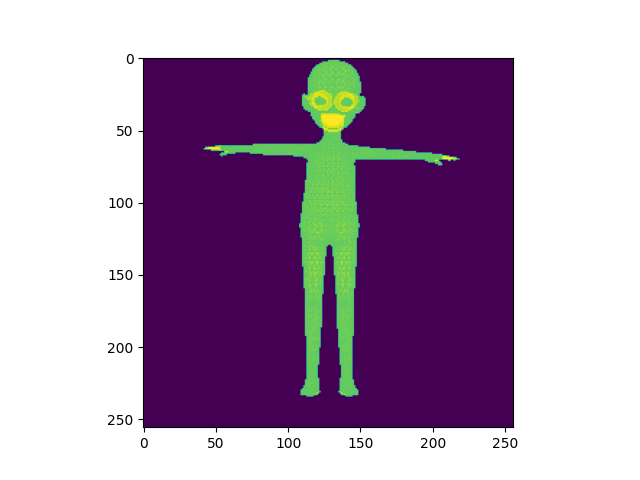

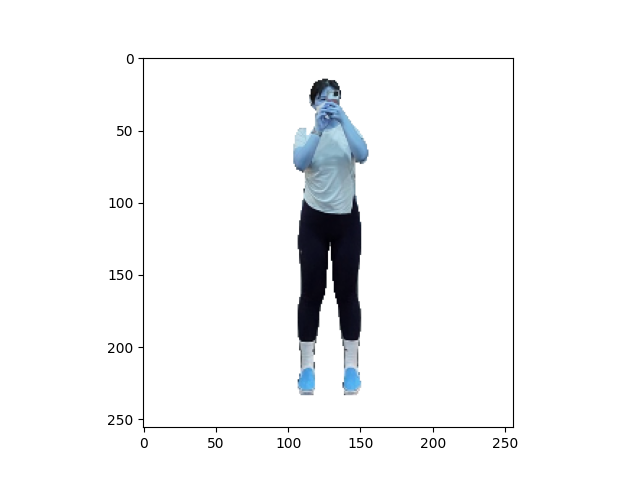

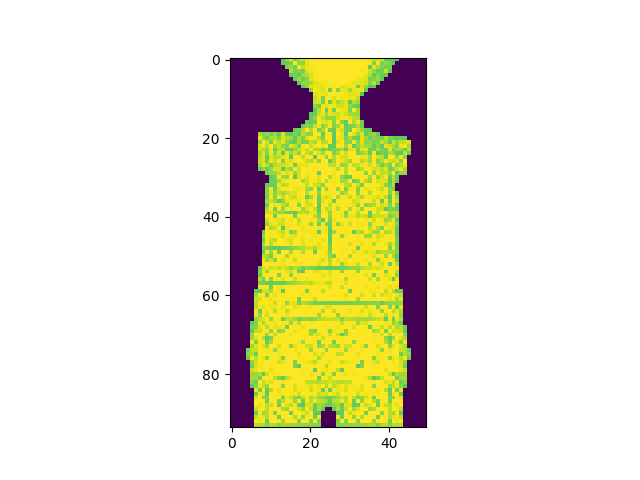

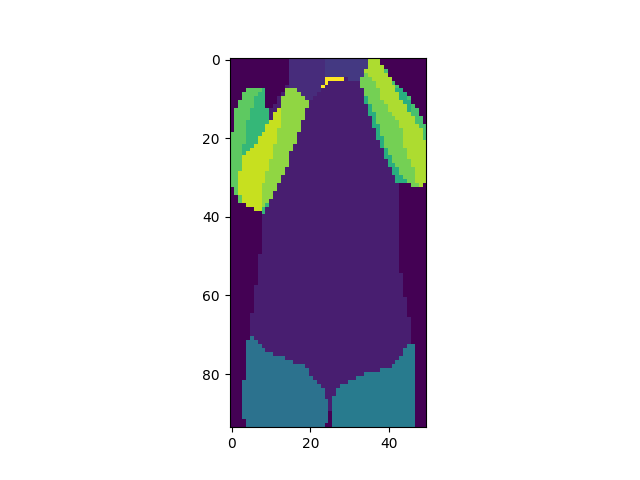

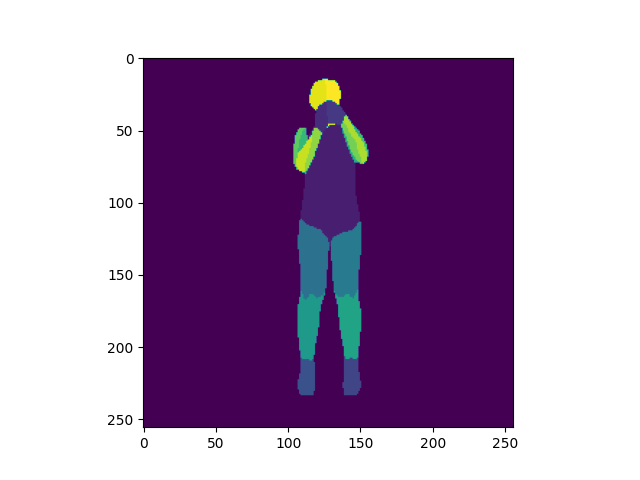

In [10]:
body_init = copy.deepcopy(body)
_vertices_opt = copy.deepcopy(_vertices)

# optimize paramters
body_init.childs[0].scale_y(opt_x[0], _vertices_opt)
body_init.childs[0].childs[0].scale_y(opt_x[1], _vertices_opt)
body_init.childs[0].childs[0].childs[0].scale_y(opt_x[2], _vertices_opt)

# Prior result
## spine
body_init.childs[0].scale_iso_hier(opt_upper_scale[0], _vertices_opt)
body_init.childs[0].rot(_rot_base('z', opt_upper_rot[0]), _vertices_opt, inplace=False)
## chestupper
body_init.childs[0].childs[0].childs[0].rot(_rot_base('z', opt_upper_rot[1]), _vertices_opt, inplace=False)
## shoulder
body_init.childs[0].childs[0].childs[0].childs[1].scale_iso_hier(opt_upper_scale[1], _vertices_opt)
body_init.childs[0].childs[0].childs[0].childs[2].scale_iso_hier(opt_upper_scale[1], _vertices_opt)

img_size = min(h_sub, w_sub)
mesh._verts_packed = (
        _vertices_opt - _vertices_opt[3106,:]
        - torch.tensor([0, 0, -img_size/2])
        - torch.tensor([crotch_subimg[0], crotch_subimg[1], 0]) \
        + torch.tensor([w_sub/2, h_sub/2, 0])
        )/img_size * 2
fragments = rasterize_meshes(mesh, image_size = (h_sub, w_sub), blur_radius=0, faces_per_pixel=8, perspective_correct= False, )
blend_params = BlendParams()
res = _sigmoid_alpha(fragments[3], fragments[0], blend_params.sigma)






%matplotlib widget
plt.figure('result')
plt.imshow(np.asarray(res[0].detach()))

plt.figure('img_seg')
plt.imshow(subimg)


mesh_ = load_objs_as_meshes(['/Users/ik/Desktop/zepeto/blender/wip_find_weight.obj'], device)
# mesh_._verts_packed = (
mesh_._verts_list[0] = (
        _vertices_opt - _vertices_opt[3106,:]
        - torch.tensor([0, 0, -img_size/2])
        - torch.tensor([crotch[0], crotch[1], 0]) \
        + torch.tensor([128, 128, 0])
        )/256 * 2
fragments_whole = rasterize_meshes(mesh_, image_size = 256, blur_radius=0, faces_per_pixel=8, perspective_correct= False, )
blend_params = BlendParams()
res_whole = _sigmoid_alpha(fragments_whole[3], fragments_whole[0], blend_params.sigma)


plt.figure('result_whole')
plt.imshow(np.asarray(res_whole[0].detach()))
plt.show()

plt.figure('seg_img')
plt.imshow(img_seg)

plt.figure('original_img')
plt.imshow(img)

plt.show()